In [263]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astroML
from astroML.stats import sigmaG
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree
from astropy.timeseries import LombScargle

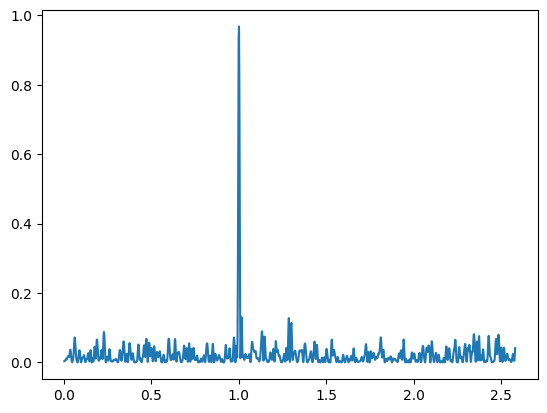

In [264]:
rand = np.random.default_rng(42)
t = 100 * rand.random(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.standard_normal(100)

frequency, power = LombScargle(t, y).autopower()
plt.plot(frequency, power)    

In [265]:
dy = 0.1
frequency, power = LombScargle(t, y, dy).autopower()

In [266]:
dy = 0.1 * (1 + rand.random(100))
y = np.sin(2 * np.pi * t) + dy * rand.standard_normal(100)
frequency, power = LombScargle(t, y, dy).autopower()

In [267]:
import astropy.units as u
t_days = t * u.day
y_mags = y * u.mag
dy_mags = y * u.mag
frequency, power = LombScargle(t_days, y_mags, dy_mags).autopower()

print(frequency.unit)
print(power.unit)

1 / d



In [268]:
frequency, power = LombScargle(t_days, y_mags, dy_mags).autopower(minimum_frequency=1e-5*u.Hz)

In [269]:
frequency, power = LombScargle(t, y, dy).autopower(nyquist_factor=2)
print(len(frequency), frequency.min(), frequency.max()) 

500 0.0010327803641893758 1.0317475838251864


In [270]:
frequency, power = LombScargle(t, y, dy).autopower(nyquist_factor=10)
print(len(frequency), frequency.min(), frequency.max())

2500 0.0010327803641893758 5.16286904058269


In [271]:
frequency = np.linspace(0.5, 1.5, 1000)
power = LombScargle(t, y, dy).power(frequency)

872


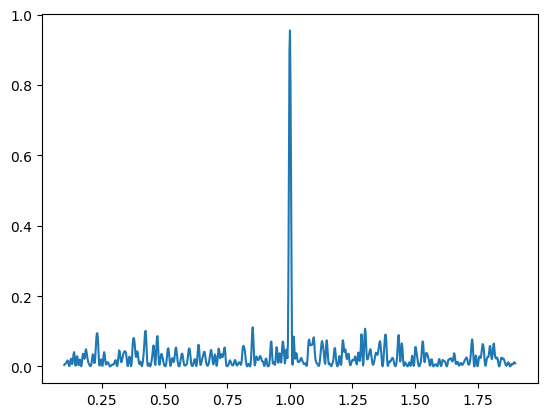

In [272]:
frequency, power = LombScargle(t, y, dy).autopower(minimum_frequency=0.1, maximum_frequency=1.9)
print(len(frequency))
plt.plot(frequency, power)

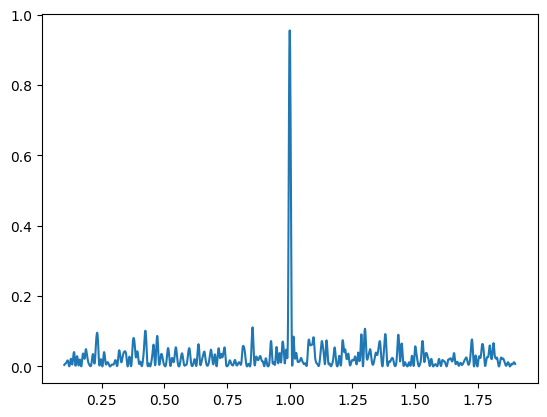

In [273]:
frequency, power = LombScargle(t, y, dy).autopower(minimum_frequency=0.1,
                                                   maximum_frequency=1.9,
                                                   samples_per_peak=10)
plt.plot(frequency, power)

<ErrorbarContainer object of 3 artists>

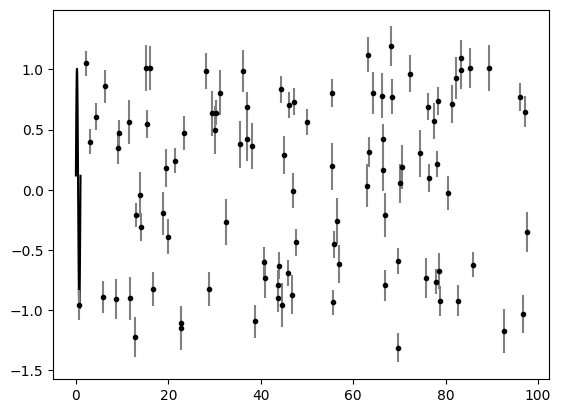

In [274]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 1)
ls = LombScargle(t, y, dy)
y_fit = ls.model(t_fit, best_frequency)

# plot the Lomb-Scargle model fit
plt.plot(t_fit, y_fit, '-k')
plt.errorbar(t, y, dy, fmt='.k', ecolor='gray')


In [275]:
theta = ls.model_parameters(best_frequency)
theta.round(2)

array([-0.01,  0.99,  0.11])

In [276]:
offset = ls.offset()
design_matrix = ls.design_matrix(best_frequency, t_fit)
np.allclose(y_fit, offset + design_matrix.dot(theta))

True

In [277]:
ls = LombScargle(t_days, y_mags, normalization='psd')
frequency, power = ls.autopower()
power.unit

Unit("mag2")

In [278]:
ls = LombScargle(t_days, y_mags, dy_mags, normalization='psd')
frequency, power = ls.autopower()
power.unit

Unit(dimensionless)

In [279]:
def fourier_periodogram(t, y):
    N = len(t)
    frequency = np.fft.fftfreq(N, t[1] - t[0])
    y_fft = np.fft.fft(y.value) * y.unit
    positive = (frequency > 0)
    return frequency[positive], (1. / N) * abs(y_fft[positive]) ** 2

In [280]:
t_days = np.arange(100) * u.day
y_mags = rand.standard_normal(100) * u.mag
frequency, PSD_fourier = fourier_periodogram(t_days, y_mags)
ls = LombScargle(t_days, y_mags, normalization='psd')
PSD_LS = ls.power(frequency)

In [281]:
u.allclose(PSD_fourier, PSD_LS)

True

In [282]:
t = 100 * rand.random(60)
dy = 1.0
y = np.sin(2 * np.pi * t) + dy * rand.standard_normal(60)
ls = LombScargle(t, y, dy)
freq, power = ls.autopower()
print(power.max())

0.29154492887882927


In [283]:
ls.false_alarm_probability(power.max())

0.028959671719328808

In [284]:
probabilities = [0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.25681381, 0.27663466, 0.31928202])

In [285]:
ls.false_alarm_probability(power.max(), method='baluev')

0.028959671719328808

In [286]:
ls.false_alarm_probability(power.max(), method='bootstrap')

0.03700000000000003

In [287]:
ls.false_alarm_probability(power.max(), method='davies')

0.029387277355227746

In [288]:
ls.false_alarm_probability(power.max(), method='naive')  

0.00810080828660202